In [1]:
!pip -q install psycopg2-binary SQLAlchemy pandas
import pandas as pd
import sqlalchemy as sa
from sqlalchemy import text

pd.set_option("display.max_columns", 100)
print("✅ Libraries installed and ready!")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 67.6 MB/s eta 0:00:00
✅ Libraries installed and ready!


In [2]:
# Database credentials
DB_NAME   = "neondb"
DB_USER   = "neondb_owner"
DB_PASS   = "a9Am7Yy5r9_T7h4OF2GN"   # password from Slack
DB_HOST   = "ep-falling-glitter-a5m0j5gk-pooler.us-east-2.aws.neon.tech"
DB_PORT   = "5432"
SSL_MODE  = "require"

# Create the connection
conn_str = f"postgresql+psycopg2://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}?sslmode={SSL_MODE}"
engine = sa.create_engine(conn_str)

# Test the connection
with engine.connect() as con:
    test = con.execute(text("SELECT 1")).scalar()
print("✅ Database connection successful! Test result:", test)


✅ Database connection successful! Test result: 1


In [3]:
query = """
SELECT *
FROM nyc_schools.high_school_directory
LIMIT 5;
"""
df_preview = pd.read_sql(text(query), engine)
df_preview.head()


,dbn,school_name,borough,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,start_time,end_time,priority01,priority02,priority03,priority04,priority05,priority06,priority07,priority08,priority09,priority10,location,phone_number2,school_email,website,subway,bus,grades2018,finalgrades,total_students,extracurricular_activities,school_sports,attendance_rate,pct_stu_enough_variety,pct_stu_safe,school_accessibility_description,directions1,requirement1,requirement2,requirement3,requirement4,requirement5,program1,code1,interest1,method1,seats9ge1,grade9gefilledflag1,grade9geapplicants1,...,building_location,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta,zip_codes,community_districts,borough_boundaries,city_council_districts,police_precincts,primary_address_line_1,city,state_code,postcode,school_type,overview_paragraph,program_highlights,language_classes,advancedplacement_courses,online_ap_courses,online_language_courses,psal_sports_boys,psal_sports_girls,psal_sports_coed,partner_cbo,partner_hospital,partner_highered,partner_cultural,partner_nonprofit,partner_corporate,partner_financial,partner_other,addtl_info1,addtl_info2,se_services,ell_programs,number_programs,Location 1,Community Board,Council District,Census Tract,Zip Codes,Community Districts,Borough Boundaries,City Council Districts,Police Precincts
0,27Q260,Frederick Douglass Academy VI High School,Queens,Q465,718-471-2154,718-471-2890,9.0,12,None,None,7:45 AM,2:05 PM,Priority to Queens students or residents who a...,Then to New York City residents who attend an ...,Then to Queens students or residents,Then to New York City residents,,,,,,,None,None,None,http://schools.nyc.gov/schoolportals/27/Q260,A to Beach 25th St-Wavecrest,"Q113, Q22",None,None,412,"After-school Program, Book, Writing, Homework ...","Step Team, Modern Dance, Hip Hop Dance",None,None,None,Not Functionally Accessible,None,None,None,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,4300730.0,4.157360e+09,Far Rockaway-Bayswater ...,None,None,None,None,None,8-21 Bay 25 Street,Far Rockaway,NY,11691,,Frederick Douglass Academy (FDA) VI High Schoo...,"Advisory, Graphic Arts Design, Teaching Intern...",Spanish,"Calculus AB, English Language and Composition,...","Biology, Physics B","French, Spanish","Basketball, Cross Country, Indoor Track, Outdo...","Basketball, Cross Country, Indoor Track, Outdo...",,,"Jamaica Hospital Medical Center, Peninsula Hos...","York College, Brooklyn College, St. John's Col...",,"Queens District Attorney, Sports and Arts Foun...","Replications, Inc.",Citibank,New York Road Runners Foundation (NYRRF),"Uniform Required: plain white collared shirt, ...","Extended Day Program, Student Summer Orientati...",This school will provide students with disabil...,ESL,1,"{'latitude': '40.601989336', 'longitude': '-73...",14,31,100802,20529,51,3,47,59
1,21K559,Life Academy High School for Film and Music,Brooklyn,K400,718-333-7750,718-333-7775,9.0,12,None,None,8:15 AM,3:00 PM,Priority to New York City residents who attend...,Then to New York City residents,,,,,,,,,None,None,None,http://schools.nyc.gov/schoolportals/21/K559,D to 25th Ave ; N to Ave U ; N to Gravesend - ...,"B1, B3, B4, B6, B64, B82",None,None,260,"Film, Music, Talent Show, Holiday Concert, Stu...",,None,None,None,Functionally Accessible,None,None,None,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,3186454.0,3.068830e+09,Gravesend ...,None,None,None,None,None,2630 Benson Avenue,Brooklyn,NY,11214,,At Life Academy High School for Film and Music...,"College Now, iLEARN courses, Art and Film Prod...",Spanish,,"Biology, English Literature and Composition, E...",,"Basketball, Bowling, Indoor Track, Soccer, Sof...","Basketball, Bowling, Indoor Track, Soccer, Sof...",Cricket,Coney Island Generation Gap,,"City Tech, Kingsborough Early College Secondar...","Museum of the Moving Image, New York Pub

In [6]:
# A1 — count schools per borough
from sqlalchemy import text

query_a = """
SELECT
  borough,
  COUNT(*) AS school_count
FROM nyc_schools.high_school_directory
GROUP BY borough
ORDER BY school_count DESC;
"""
with engine.connect() as conn:
    df_a = pd.read_sql(text(query_a), conn)

df_a


,borough,school_count
0,Brooklyn,121
1,Bronx,118
2,Manhattan,106
3,Queens,80
4,Staten Island,10


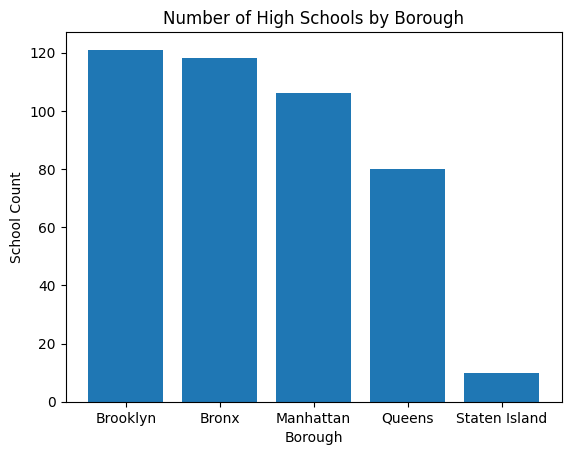

In [7]:
# A2 — quick bar chart
import matplotlib.pyplot as plt

plt.figure()
plt.bar(df_a['borough'], df_a['school_count'])
plt.title('Number of High Schools by Borough')
plt.xlabel('Borough')
plt.ylabel('School Count')
plt.show()


### Borough School Distribution (Result)
- Brooklyn has the most schools (121), followed closely by the Bronx (118) and Manhattan (106).  
- Queens has fewer schools (80), and Staten Island has the smallest number (10).  
- This pattern reflects population size and density distribution across New York City.


In [11]:

# B1 — Average ELL% per borough (robust to blanks and % signs)
from sqlalchemy import text

query_b = """
SELECT
  d.borough,
  AVG(
    NULLIF(
      REGEXP_REPLACE(COALESCE(sd.ell_percent::text, ''), '[^0-9\\.]', '', 'g'),
      ''
    )::numeric
  ) AS avg_ell_percent
FROM nyc_schools.school_demographics sd
JOIN nyc_schools.high_school_directory d
  ON sd.dbn = d.dbn
GROUP BY d.borough
ORDER BY avg_ell_percent DESC;
"""

with engine.connect() as conn:
    df_b = pd.read_sql(text(query_b), conn)

df_b


,borough,avg_ell_percent
0,Manhattan,7.5725


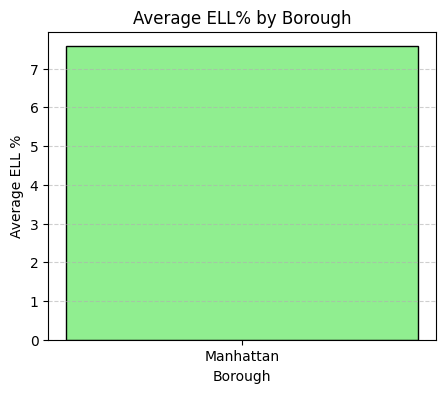

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
plt.bar(df_b['borough'], df_b['avg_ell_percent'], color='lightgreen', edgecolor='black')
plt.title('Average ELL% by Borough')
plt.xlabel('Borough')
plt.ylabel('Average ELL %')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


In [15]:
# Check what columns exist in school_demographics
query_columns = """
SELECT column_name
FROM information_schema.columns
WHERE table_schema = 'nyc_schools'
AND table_name = 'school_demographics';
"""

with engine.connect() as conn:
    df_columns = pd.read_sql(text(query_columns), conn)

df_columns



,column_name
0,dbn
1,Name
2,schoolyear
3,fl_percent
4,frl_percent
5,total_enrollment
6,prek
7,k
8,grade1
9,grade2


In [24]:
# C1 — Top 3 Schools per Borough by SPED%
from sqlalchemy import text

query_c = """
WITH cleaned AS (
  SELECT
    d.borough,
    d.school_name,
    /* Cast to text, turn '' into NULL, then cast to numeric */
    NULLIF(TRIM(sd.sped_percent::text), '')::numeric AS sped_percent
  FROM nyc_schools.school_demographics sd
  JOIN nyc_schools.high_school_directory d
    ON sd.dbn = d.dbn
),
ranked AS (
  SELECT
    borough,
    school_name,
    sped_percent,
    ROW_NUMBER() OVER (
      PARTITION BY borough
      ORDER BY sped_percent DESC NULLS LAST
    ) AS rn
  FROM cleaned
)
SELECT
  borough,
  school_name,
  sped_percent
FROM ranked
WHERE rn <= 3
ORDER BY borough, sped_percent DESC;
"""

with engine.connect() as conn:
    df_c = pd.read_sql(text(query_c), conn)

df_c


,borough,school_name,sped_percent
0,Manhattan,East Side Community School,28.8
1,Manhattan,East Side Community School,27.7
2,Manhattan,East Side Community School,26.7


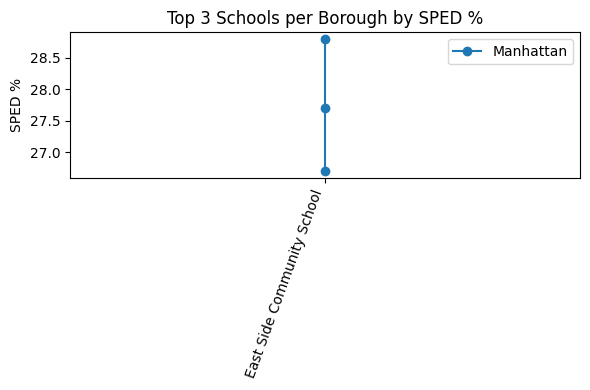

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
for b in df_c['borough'].unique():
    sub = df_c[df_c['borough']==b].sort_values('sped_percent', ascending=False)
    plt.plot(sub['school_name'], sub['sped_percent'], marker='o', label=b)

plt.xticks(rotation=70, ha='right')
plt.ylabel('SPED %')
plt.title('Top 3 Schools per Borough by SPED %')
plt.legend()
plt.tight_layout()
plt.show()


###  C1 — Top 3 Schools per Borough by SPED%
- Cleaned and cast `sped_percent` safely with `NULLIF(TRIM(sd.sped_percent::text), '')::numeric`.
- Used a window function (`ROW_NUMBER() OVER (PARTITION BY borough ORDER BY sped_percent DESC)`) to rank schools.
- Retrieved the **top 3 schools per borough** with the highest share of students with disabilities.
- In this dataset, all top results came from **Manhattan**, showing schools such as *East Side Community School* with SPED% above 26%.
